应用于最后一步模拟数据&真实数据的预处理管线
# 加载数据
加载数据的方式真实数据和模拟数据之间可能有所差异

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import json
import george

In [3]:
from matplotlib import font_manager

In [4]:
font_manager.fontManager.addfont("/home/yltang/data/Times_New_Roman.ttf")

In [5]:
plt.style.use("seaborn-v0_8-paper")
font1 = {'family': 'Times New Roman',
         #'weight': 'normal',
         'size':15,
         }

In [6]:
# 使用 seaborn 的颜色调色板
import seaborn as sns
color = sns.color_palette("bright", n_colors=10)

In [7]:
# 读取 JSON 文件
with open(f'/home/yltang/data/simulated_data_1/data_new/SNIa/data/SNIa_13_1.json', 'r') as file:
    data_list = json.load(file)

with open(f"/home/yltang/data/simulated_data_1/data_new/SNIa/redshift/SNIa_redshift_13_1.json","r") as file:
    redshift = json.load(file)

In [8]:
len(data_list), len(redshift)

(1885, 1885)

In [9]:
def trigger(data):
    """
    """
    trigger_list = []
    for index in range(len(data)):
        mjd_ = data[index][0][1]
        flux_ = data[index][1][1]
        flux_err_ = data[index][2][1]
        #print(len(flux_), len(flux_err_))
        max_index = np.argmax(flux_)
        for j, _ in enumerate(flux_):
            if flux_[j] > 5*flux_err_[j]:
                trigger = mjd_[j]
                break
        #print(trigger, max_index)
        trigger_list.append(trigger)
       

    return (trigger_list)

In [10]:
trigger_list = trigger(data=data_list)

In [11]:
len(trigger_list)

1885

In [12]:
trigger_list[:10]

[38.0, 36.0, 35.0, 36.0, 34.0, 39.0, 38.0, 34.0, 39.0, 37.0]

# GPS fit
调用make_dense.py方法

## 先尝试对单个样本

In [13]:
sample = 0

### 将列表数据转化为np.array

In [16]:
sample += 1

In [31]:
mjd = []
flux = []
flux_err = []
for i in range(3):
    mjd_ = data_list[sample][0][i]
    flux_ = data_list[sample][1][i]
    flux_err_ = data_list[sample][2][i]
    
    mjd_ = np.array(mjd_)
    flux_ = np.array(flux_)
    flux_err_ = np.array(flux_err_)
    
    mjd.append(mjd_)
    flux.append(flux_)
    flux_err.append(flux_err_)    

In [32]:
lc = [mjd, flux, flux_err]

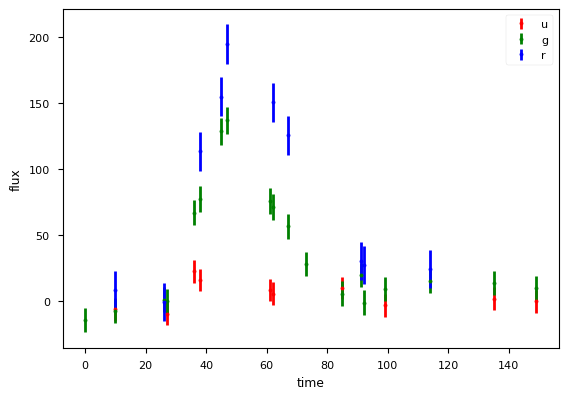

In [33]:
markers = ["d", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "+"]
#color = ['r','g','b','k','y','m']
#fmt = ['dr','og','vb','^k','<y','>m']
#用不同的颜色代表不同波段, 不同形状代表不同数据
fmt_1 = ['.r','.g','.b','.k','.y','.m']
fmt_2 = ['dr','dg','db','dk','dy','dm']
label = ['u','g','r','i','z','w']
for i in range(3):
    mjd_ = lc[0][i]
    flux_ = lc[1][i]
    flux_err_ = lc[2][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

In [20]:
sys.path.append("/home/yltang/data/lc_processor/python_code/tools")
from make_dense_light_curve_effective import make_dense_light_curve
make_dense = make_dense_light_curve(light_curve=None)

In [21]:
concatnet_lc = make_dense.concatenate_lc(light_curve_info=lc)

Text(0, 0.5, 'flux')

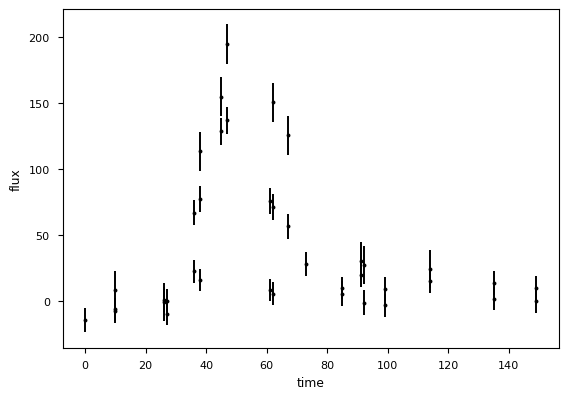

In [22]:
time = concatnet_lc[0]
fluxes = concatnet_lc[1]
flux_errs = concatnet_lc[2]
filters = concatnet_lc[3]
plt.errorbar(x=time, y=fluxes, yerr=flux_errs, fmt=".k", capsize=2)
plt.xlabel("time")
plt.ylabel("flux")

In [23]:
gp_ = make_dense.fit_gps(concat_lc=concatnet_lc)
central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = np.array(central_wave_length)

(2, 500) (39,)
(2, 500) (39,)
(2, 500) (39,)


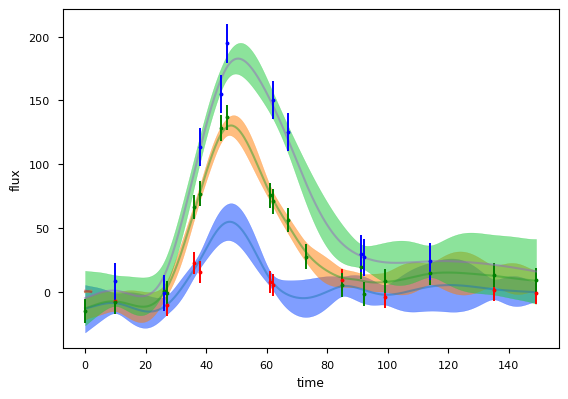

In [24]:
for band in range(3):
    x_pred = np.linspace(min(time), max(time), 500)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    print(x_pred.shape,fluxes.shape)
    plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.5)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(lc[0][band], lc[1][band], yerr=lc[2][band], fmt=fmt_1[band], capsize=0)


    plt.xlabel("time")
    plt.ylabel("flux")

## data mask

In [25]:
mask_lc = lc

In [26]:
mask_date = 40
print(mask_date)
for band in range(3):
    delete_index = []
    """
    mask_mjd = lc[0][band]
    mask_flux = lc[1][band]
    mask_flux_err = lc[2][band]
    """
    for i, mjd_ in enumerate(lc[0][band]):
        if mjd_>mask_date:
            delete_index.append(i)
    print(delete_index)
    #mask_lc[0][band] = lc[0][band].copy()
    #mask_lc[1][band] = lc[1][band].copy()
    #mask_lc[2][band] = lc[2][band].copy()
    mask_lc[0][band] = np.delete(mask_lc[0][band], delete_index)
    mask_lc[1][band] = np.delete(mask_lc[1][band], delete_index)
    mask_lc[2][band] = np.delete(mask_lc[2][band], delete_index)

40
[4, 5, 6, 7, 8, 9]
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[3, 4, 5, 6, 7, 8, 9]


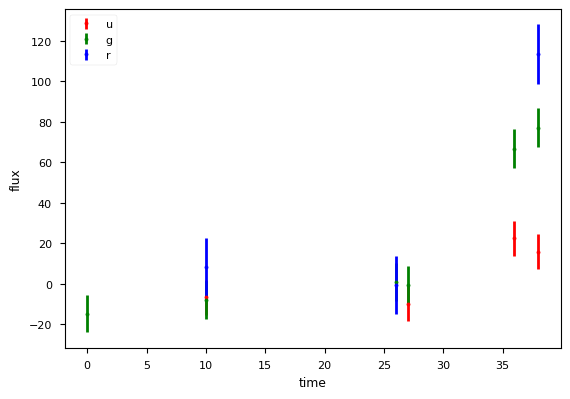

In [27]:
for i in range(3):
    mask_mjd = mask_lc[0][i]
    mask_flux = mask_lc[1][i]
    mask_flux_err = mask_lc[2][i]

    plt.errorbar(x=mask_mjd, y=mask_flux, yerr=mask_flux_err, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

Text(0, 0.5, 'flux')

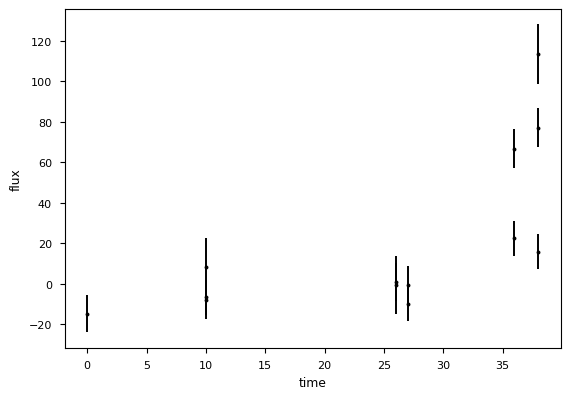

In [28]:
mask_concatnet_lc = make_dense.concatenate_lc(light_curve_info=mask_lc)
mask_time = mask_concatnet_lc[0]
mask_fluxes = mask_concatnet_lc[1]
mask_flux_errs = mask_concatnet_lc[2]
mask_filters = mask_concatnet_lc[3]
plt.errorbar(x=mask_time, y=mask_fluxes, yerr=mask_flux_errs, fmt=".k", capsize=2)
plt.xlabel("time")
plt.ylabel("flux")

In [29]:
mask_gp_ = make_dense.fit_gps(concat_lc=mask_concatnet_lc)
central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = np.array(central_wave_length)

### 对比mask后的拟合和没有mask拟合之间的区别

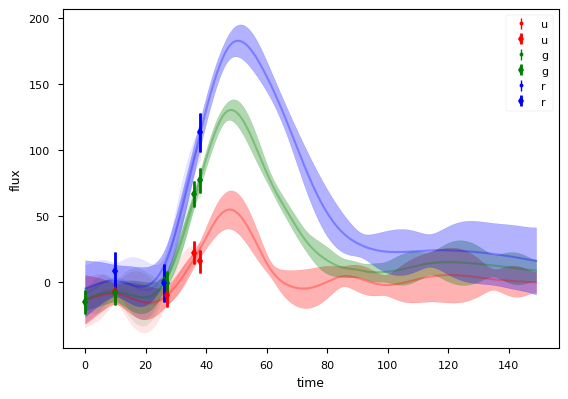

In [30]:
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
for band in range(3):
    mjd = lc[0][band]
    flux = lc[1][band]
    flux_err = lc[2][band]
    
    mask_mjd = mask_lc[0][band]
    mask_flux = mask_lc[1][band]
    mask_flux_err = mask_lc[2][band]

    x_pred = np.linspace(min(time), max(time), 500)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.3)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.3)
    plt.errorbar(x=mjd, y=flux, yerr=flux_err, fmt=fmt_1[band], elinewidth=1, capsize=1,label=label[band])
    
    mask_x_pred = np.linspace(min(mask_time), max(mask_time), 500)
    mask_x_pred = np.vstack([mask_x_pred,np.ones(mask_x_pred.shape)*central_wave_length[band]])
    mask_pred, mask_pred_var = mask_gp_.predict(mask_fluxes, mask_x_pred.T, return_var=True)
    mask_x_pred_ = mask_x_pred[0,:]
    plt.fill_between(mask_x_pred_, mask_pred - np.sqrt(mask_pred_var), mask_pred + np.sqrt(mask_pred_var),
                color=color[band], alpha=0.1)
    plt.plot(mask_x_pred_, mask_pred, color[band], lw=1.5, alpha=0.1)
    plt.errorbar(x=mask_mjd, y=mask_flux, yerr=mask_flux_err, fmt=fmt_2[band], elinewidth=2, capsize=2,label=label[band])

    plt.legend()

    plt.xlabel("time")
    plt.ylabel("flux")

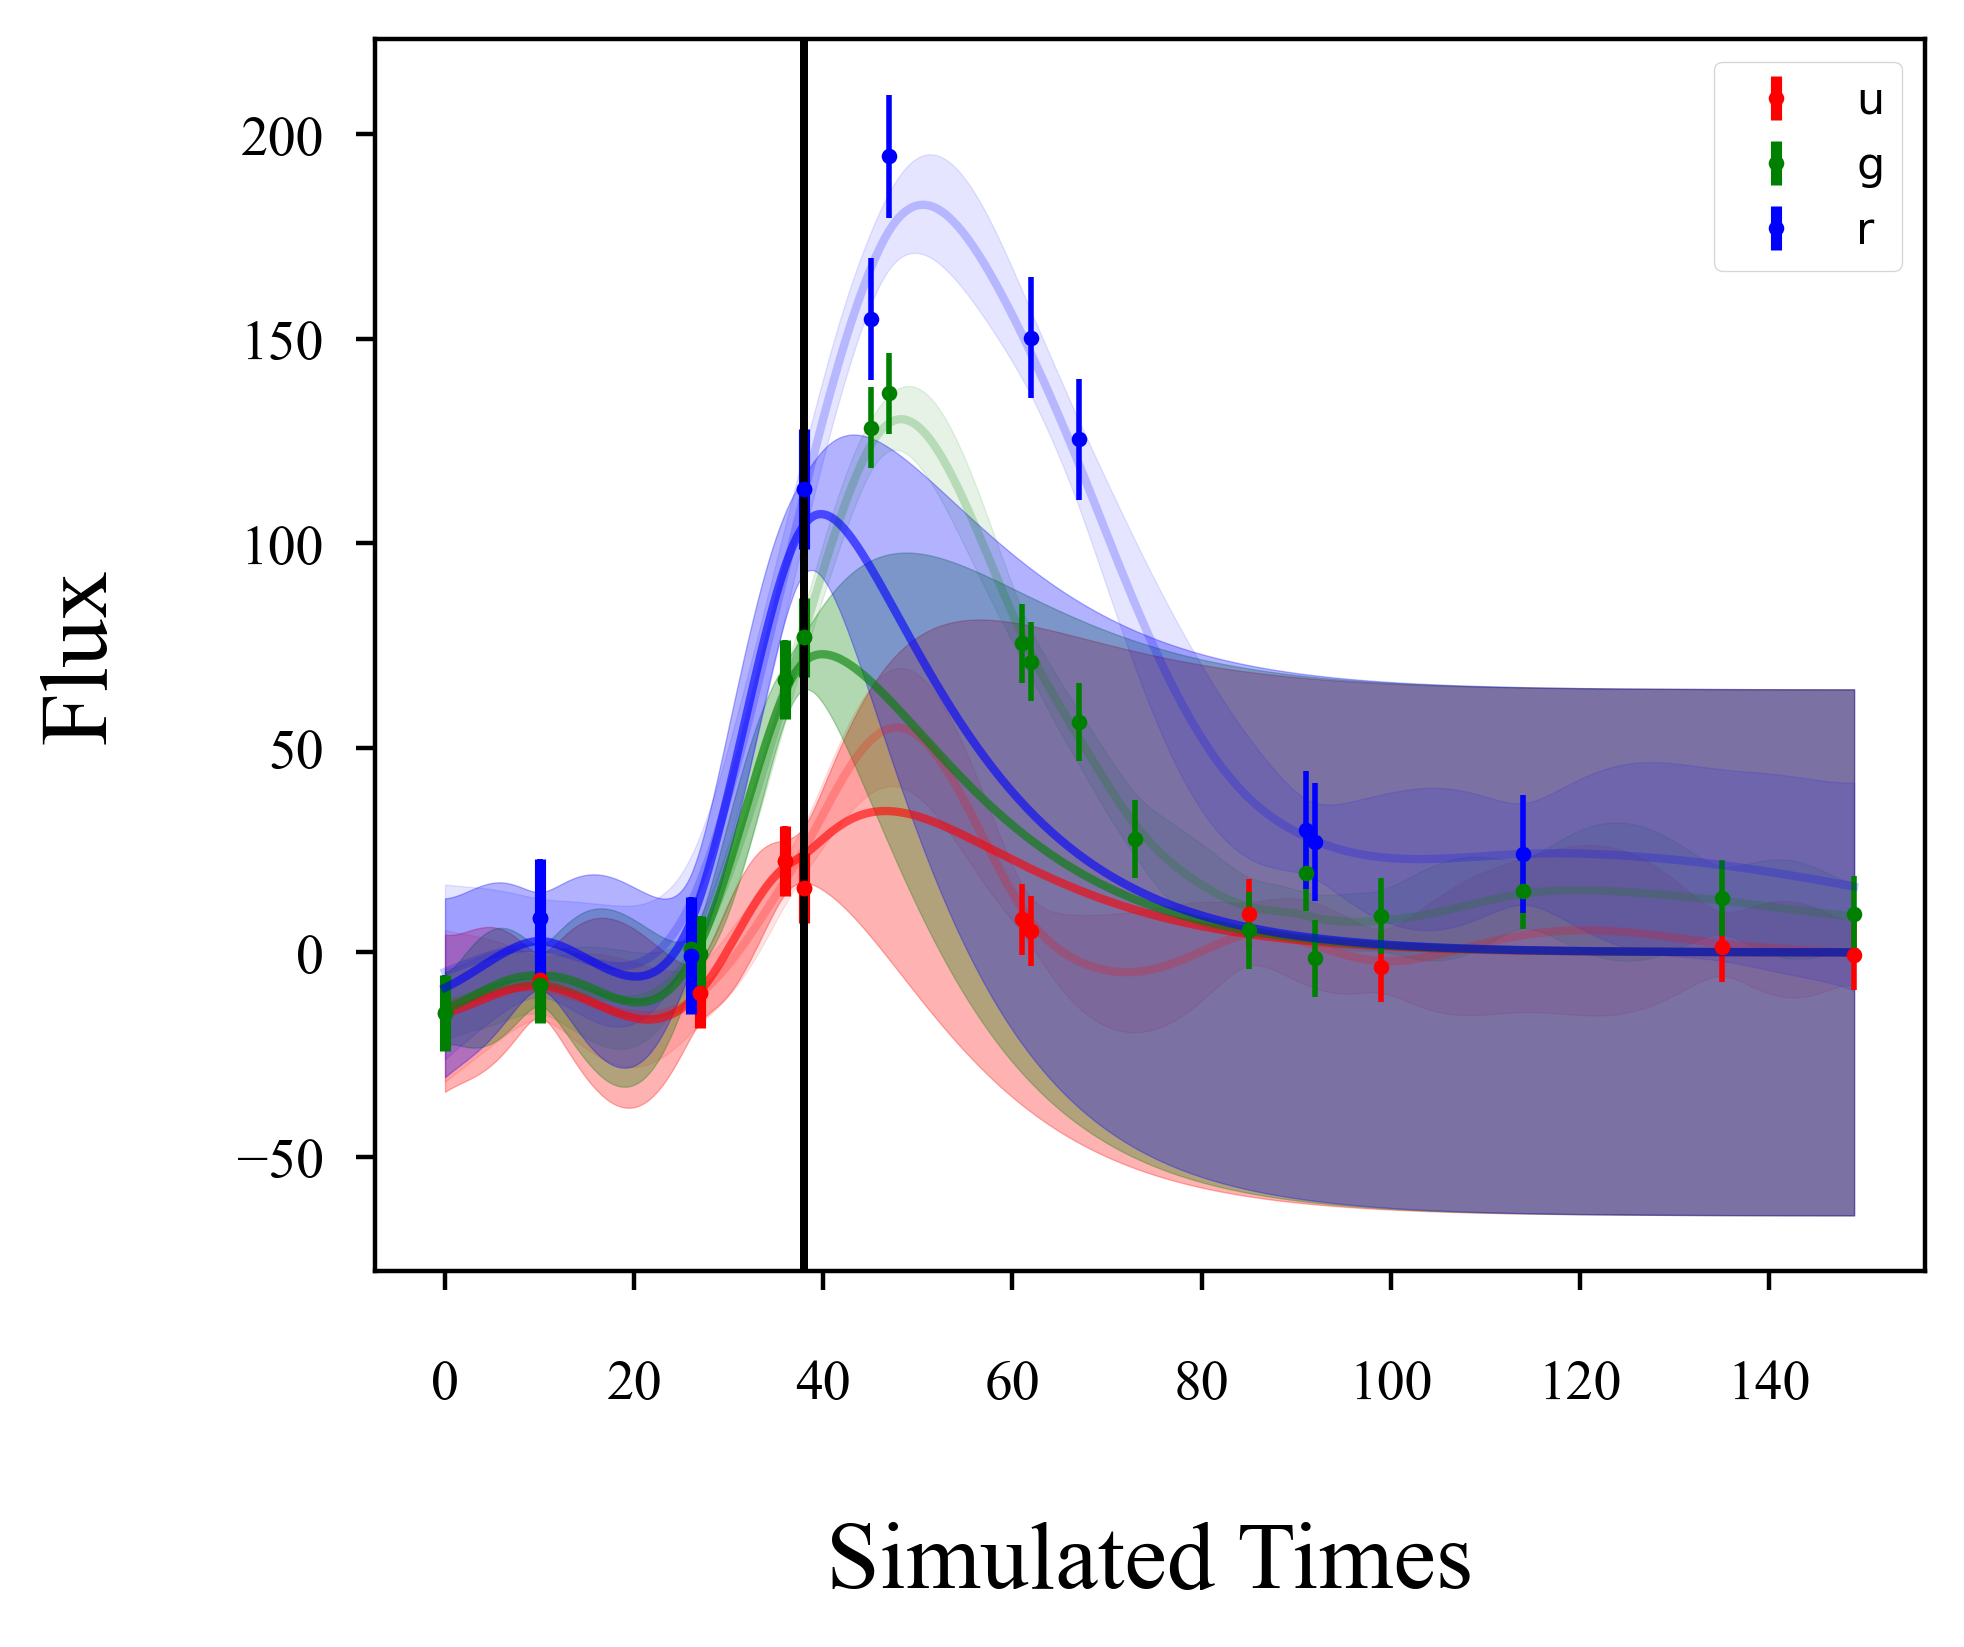

In [34]:
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']

plt.figure(figsize=(5,4),
          dpi=400)
for band in range(3):
    mjd = lc[0][band]
    flux = lc[1][band]
    flux_err = lc[2][band]
    
    mask_mjd = mask_lc[0][band]
    mask_flux = mask_lc[1][band]
    mask_flux_err = mask_lc[2][band]
    
    mask_x_pred = np.linspace(min(time), max(time), 500)
    mask_x_pred = np.vstack([mask_x_pred,np.ones(mask_x_pred.shape)*central_wave_length[band]])
    mask_pred, mask_pred_var = mask_gp_.predict(mask_fluxes, mask_x_pred.T, return_var=True)
    mask_x_pred_ = mask_x_pred[0,:]
    plt.fill_between(mask_x_pred_, mask_pred - np.sqrt(mask_pred_var), mask_pred + np.sqrt(mask_pred_var),
                color=color[band], alpha=0.3)
    plt.plot(mask_x_pred_, mask_pred, color[band], lw=1.5, alpha=0.6)
    plt.errorbar(x=mask_mjd, y=mask_flux, yerr=mask_flux_err, fmt=fmt_1[band], elinewidth=2, capsize=2,label=label[band])

    x_pred = np.linspace(min(time), max(time), 500)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
               color=color[band], alpha=0.1)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.2)
    plt.errorbar(x=mjd, y=flux, yerr=flux_err, fmt=fmt_1[band], elinewidth=1, capsize=1)

    plt.axvline(x=mask_date-2, color='k')

    plt.xlabel("Simulated Times",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.ylabel("Flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")

    plt.xticks(fontsize="xx-large",position=(0, -0.03),fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")

    plt.legend()

plt.savefig("GPs_interpolation.jpg")

In [64]:
sample

3

## 数据增强

In [60]:
central_wave_length

array([ 3570.,  4767.,  6215.,  7545.,  8708., 10040.])

In [82]:
x_pred_list = []
pred_list = []
pred_var_list = []

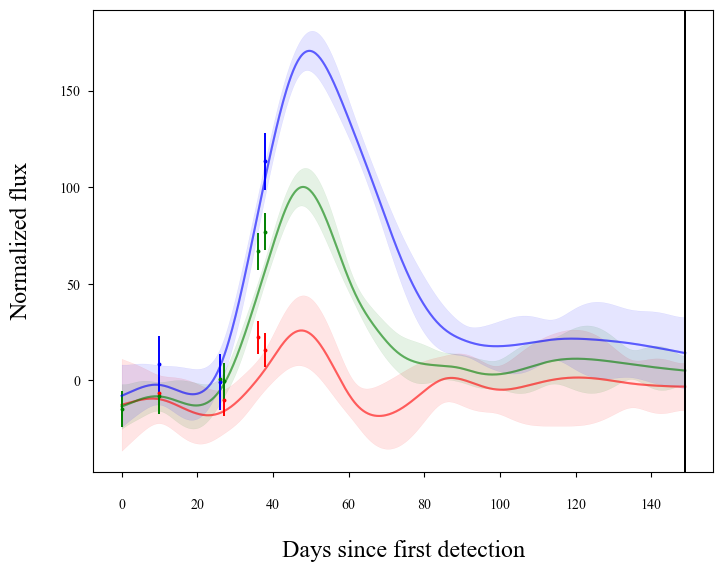

In [83]:
plt.figure(figsize=(8,6))
x_pred_list_ = []
pred_list_ = []
pred_var_list_ = []

for band in range(3):
    x_pred = np.linspace(min(time), max(time), 500)
    #print(x_pred)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*(central_wave_length[band]-500)])
    pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    
    x_pred_list_.append(x_pred)
    pred_list_.append(pred)
    pred_var_list_.append(pred_var)
    
    plt.fill_between(x_pred_, pred -  np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.1)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0)
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.2)
    
    plt.xlabel("Days since first detection",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.ylabel("Normalized flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")

    plt.xticks(fontsize="xx-large",position=(0, -0.03),fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")
    plt.axvline(x=max(time),color="k")

    #plt.savefig(f"Real_time_interpolation_{observable_data}.jpg",bbox_inches='tight')

In [67]:
x_pred_list.append(x_pred_list_)
pred_list.append(pred_list_)
pred_var_list.append(pred_var_list_)

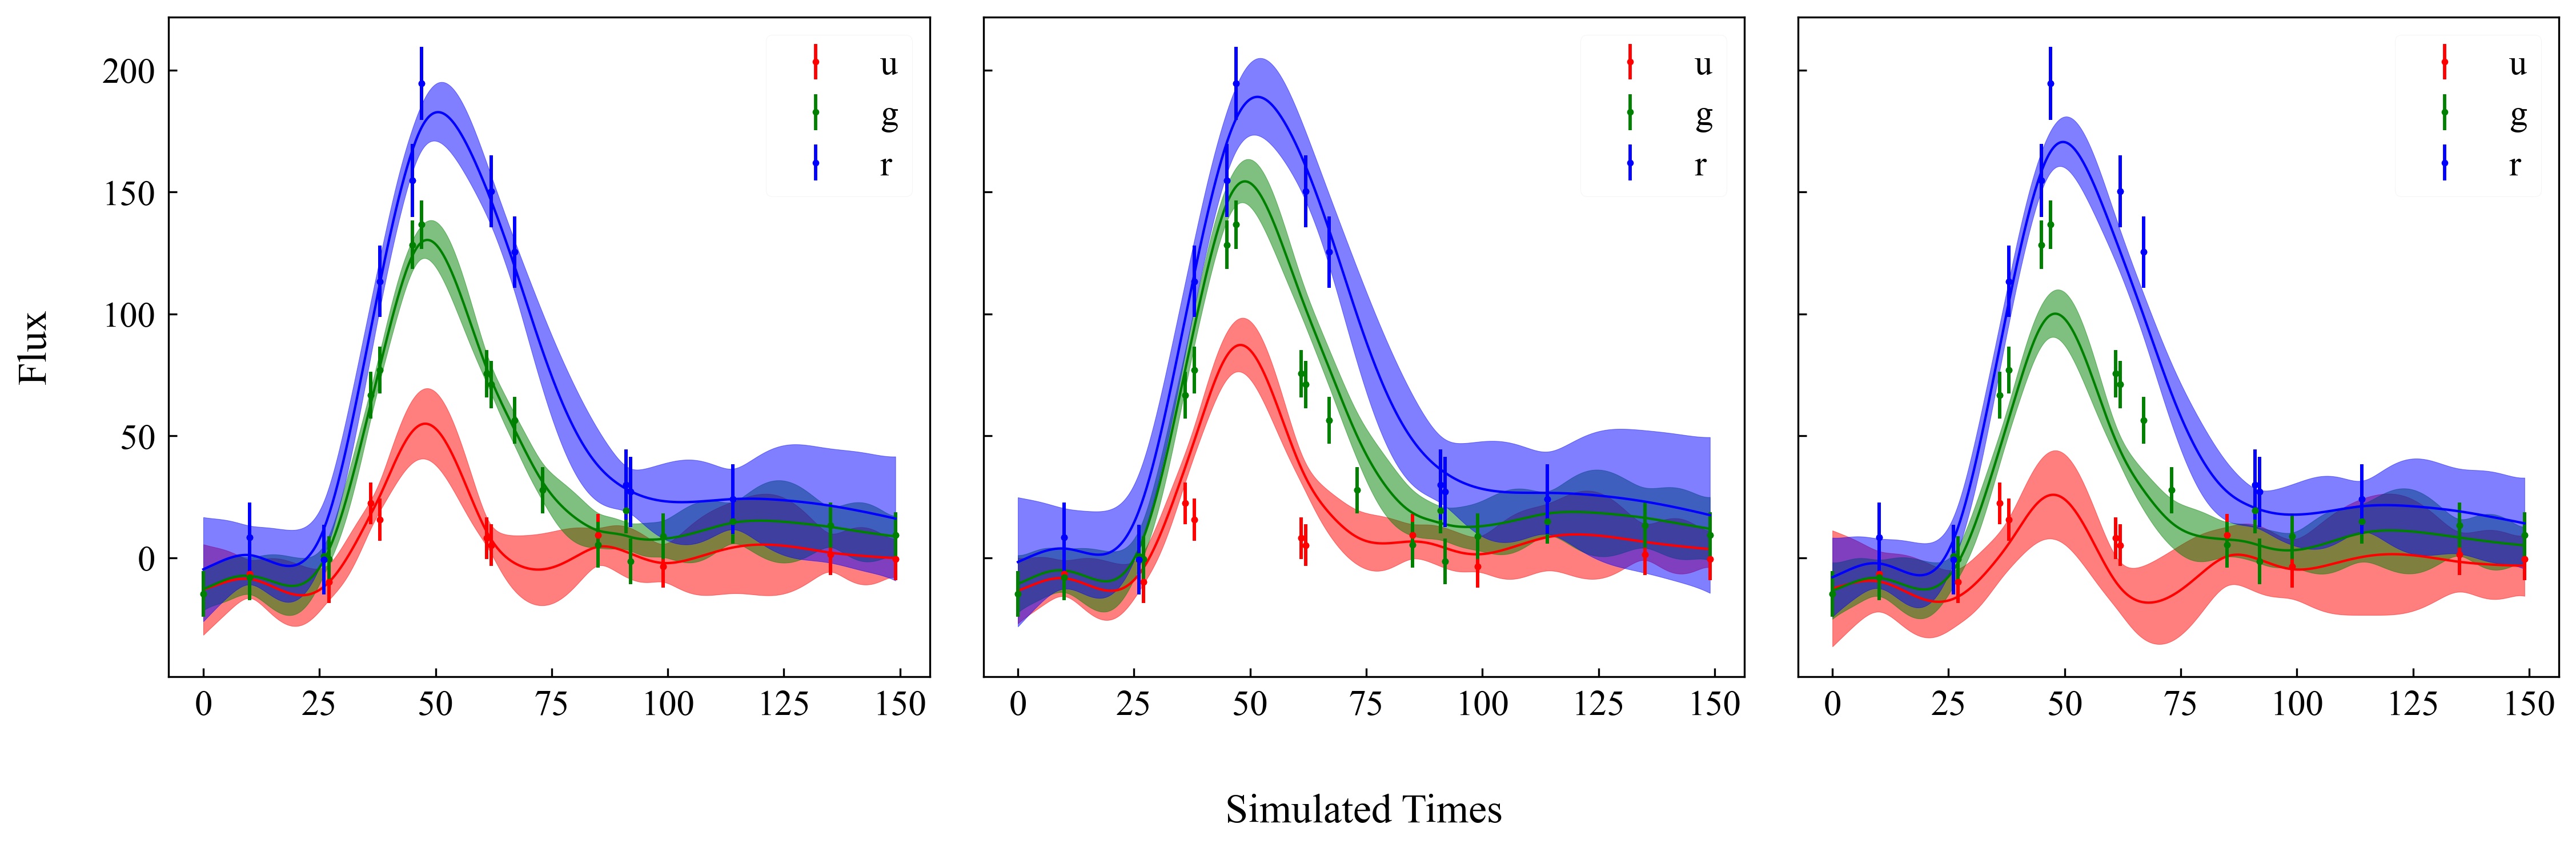

In [68]:
# 1. 相关模块导入
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 正常显示中文字体
#plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 3. 绘图
  # 3.1 共享y轴
figure,(ax1,ax2,ax3) = plt.subplots(1,3,
                                    figsize=(6*3,5),
                                    dpi=300,
                                    # 共享y轴
                                    sharey=True)

# 2. 创建制图数据
ax_list = [ax1,ax2,ax3]
for i in range(3):
    for band in range(3):
        x_pred = x_pred_list[i]
        #print(x_pred)
        #x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[i]])
        #pred, pred_var = gp.predict(fluxes, x_pred.T, return_var=True)
        pred = pred_list[i][band]
        pred_var = pred_var_list[i][band]
        x_pred_ = x_pred[band][0,:]
        ax_list[i].fill_between(x_pred_-min(x_pred_), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                   color=color[band], alpha=0.5)
        ax_list[i].plot(x_pred_-min(x_pred_), pred, color[band], lw=1.0, alpha=1.0)
        #plt.xlim(10,120)
        ax_list[i].errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0,label=label[band])
        ax_list[i].errorbar(mjd[band], flux[band], yerr= flux_err[band], fmt=fmt[band], capsize=0)
        #ax_list[j].errorbar(x=mjd_1, y=flux_list[j], yerr=flux_err_list[j],color=color[i], marker=markers[i], capsize=2,label=label[i])
        
        if i==0:
            ax_list[i].set_ylabel("Flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
        elif i==1:
            ax_list[i].set_xlabel("Simulated Times",fontsize="xx-large", labelpad=30,fontproperties="Times New Roman")

        ax_list[i].legend(fontsize="xx-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="upper right",
                      framealpha=0.2,
                      prop=font1
                     )
        
        #设置坐标轴字体
        x1_label = ax_list[i].get_xticklabels() 
        [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
        y1_label = ax_list[i].get_yticklabels() 
        [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    
        ax_list[i].set
        # 2.4 坐标轴刻度字体颜色设置
        ax_list[i].tick_params(axis='y',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 
    
        ax_list[i].tick_params(axis='x',
                     labelsize=15, # y轴字体大小设置
                     #color='r',    # y轴标签颜色设置  
                     #labelcolor='b', # y轴字体颜色设置
                     direction='in' # y轴标签方向设置
                      ) 


# 调整子图形之间的纵向距离
figure.subplots_adjust(wspace=0.07) 

plt.savefig("GP_augmentation.jpg",bbox_inches='tight')

plt.show()

## 对所有样本批量化进行

### 批量化gp fit

In [14]:
gp_parameter_list = []
sample_size = len(data_list)

In [15]:
sys.path.append("/home/yltang/data/lc_processor/python_code/tools")
from make_dense_light_curve_effective import make_dense_light_curve
make_dense = make_dense_light_curve(light_curve=None)

In [16]:
lc_list = []
concated_lc_list = []
fit_fail_list = []
with tqdm(total=sample_size*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
    for sample in range(len(data_list)):
        mjd = []
        flux = []
        flux_err = []
        for i in range(3):
            mjd_ = data_list[sample][0][i]
            flux_ = data_list[sample][1][i]
            flux_err_ = data_list[sample][2][i]
            mjd_ = np.array(mjd_)
            flux_ = np.array(flux_)
            flux_err_ = np.array(flux_err_)
            mjd.append(mjd_)
            flux.append(flux_)
            flux_err.append(flux_err_)
        
        lc = [mjd, flux, flux_err]
        concatnet_lc = make_dense.concatenate_lc(light_curve_info=lc)
        try:
            gp_ = make_dense.fit_gps(concat_lc=concatnet_lc)
            lc_list.append(lc)
            concated_lc_list.append(concatnet_lc)
            gp_parameter_list.append(gp_)
        except:
            fit_fail_list.append(sample)
            print(f"GP failed to fit this data: index{sample}")
            
        
        pbar.update(10)

Processing...: 100%|█████████████████████████████████████████████| 8.93k/8.93k [00:15<00:00, 589B/s]


In [17]:
fit_fail_list

[]

In [18]:
len(gp_parameter_list), len(lc_list), len(concated_lc_list),sample_size

(893, 893, 893, 893)

In [19]:
sample = 0

In [20]:
sample += 1

In [21]:
lc = lc_list[sample]
concatnet_lc = concated_lc_list[sample]
gp_ = gp_parameter_list[sample]

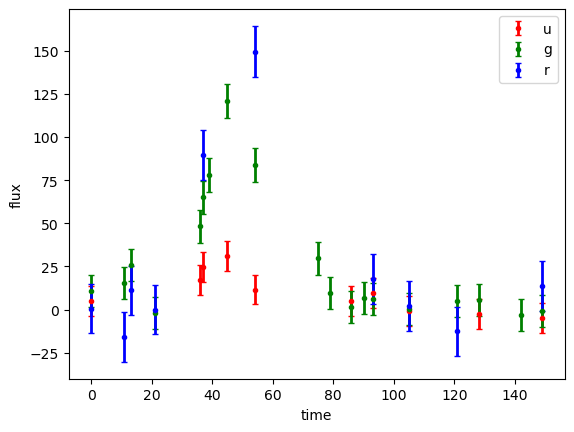

In [22]:
#用不同的颜色代表不同波段, 不同形状代表不同数据
fmt_1 = ['.r','.g','.b','.k','.y','.m']
fmt_2 = ['dr','dg','db','dk','dy','dm']
color = ['r','g','b','k','y','m']
label = ['u','g','r','i','z','w']
for i in range(3):
    mjd_ = lc[0][i]
    flux_ = lc[1][i]
    flux_err_ = lc[2][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

Text(0, 0.5, 'flux')

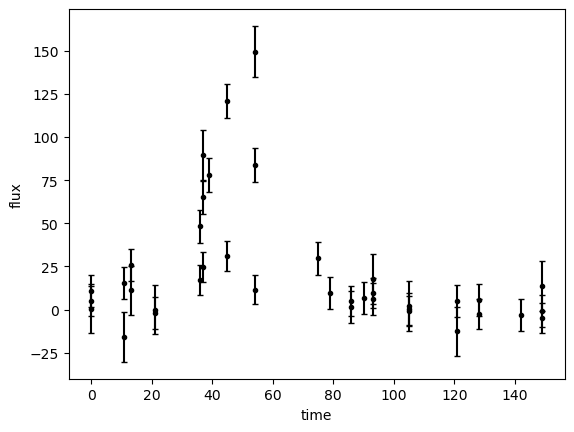

In [23]:
time = concatnet_lc[0]
fluxes = concatnet_lc[1]
flux_errs = concatnet_lc[2]
filters = concatnet_lc[3]
plt.errorbar(x=time, y=fluxes, yerr=flux_errs, fmt=".k", capsize=2)
plt.xlabel("time")
plt.ylabel("flux")

(2, 500) (39,)
(2, 500) (39,)
(2, 500) (39,)


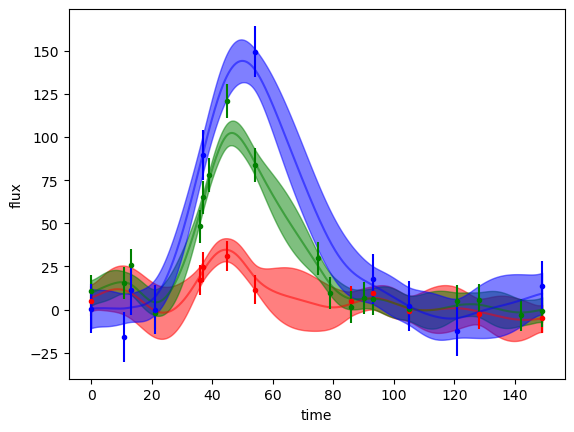

In [24]:
central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = np.array(central_wave_length)
for band in range(3):
    x_pred = np.linspace(min(time), max(time), 500)
    x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
    pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
    x_pred_ = x_pred[0,:]
    print(x_pred.shape,fluxes.shape)
    plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color=color[band], alpha=0.5)
    """
    plt.fill_between(x_pred_, pred - pred_var, pred + pred_var,
                color=color[band], alpha=0.5)
    """
    plt.plot(x_pred_, pred, color[band], lw=1.5, alpha=0.5)
    plt.errorbar(lc[0][band], lc[1][band], yerr=lc[2][band], fmt=fmt_1[band], capsize=0)


    plt.xlabel("time")
    plt.ylabel("flux")

In [25]:
a = [1,2,3,4,5]
a1 = 1
a1 in a

True

In [26]:
max(time), min(time), int(max(time)-min(time))

(149.0, 0.0, 149)

In [27]:
a =  list(np.ones(shape=(10,)))
a

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [28]:
def interpolation(lc):
    mjd_list = []
    flux_list = []
    flux_err_list = []
    weight = []
    for band in range(3):
        x_pred = np.linspace(min(time), max(time), int(max(time)-min(time))+1)
        x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
        pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
        x_pred_ = x_pred[0,:]
        #print(x_pred_)

        mjd = x_pred_
        flux = pred
        flux_err = np.sqrt(pred_var)
        weight_pre_band = list(np.zeros(shape=(len(mjd),)))
        
        for i, generate_mjd in enumerate(mjd):
            for j, real_mjd in enumerate(lc[0][band]):
                if generate_mjd == real_mjd:
                    #print(generate_mjd, real_mjd)
                    flux[i] = lc[1][band][j]
                    flux_err[i] = lc[2][band][j]
                    weight_pre_band[i] = 1.
                    #print(weight_pre_band[i])
                    break
                    
        #print(weight_pre_band)       
        mjd_list.append(mjd)
        flux_list.append(flux)
        flux_err_list.append(flux_err)
        weight.append(weight_pre_band)

    interpolated_data = [mjd_list, flux_list, flux_err_list]
    return interpolated_data, weight

In [29]:
interpolated_data, weight = interpolation(lc=lc)

In [30]:
a =np.ones(5,)
b = np.array([1,2,3,4,5])
a, b

(array([1., 1., 1., 1., 1.]), array([1, 2, 3, 4, 5]))

In [31]:
a * b

array([1., 2., 3., 4., 5.])

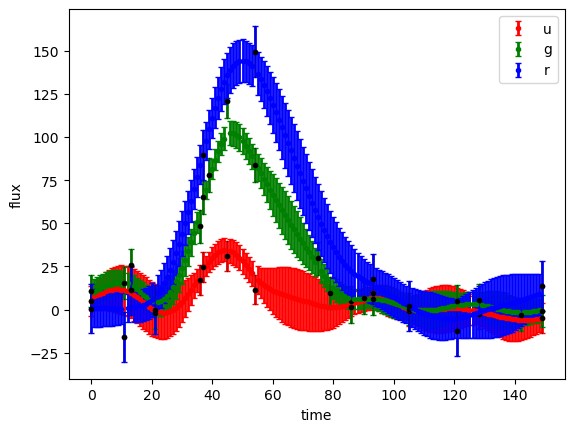

In [32]:
for i in range(3):
    mjd_ = interpolated_data[0][i]
    flux_ = interpolated_data[1][i]
    flux_err_ = interpolated_data[2][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.errorbar(x=lc[0][i], y=lc[1][i], yerr=lc[2][i], fmt=".k", elinewidth=0.2, capsize=0.2)
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")
    #print(weight)

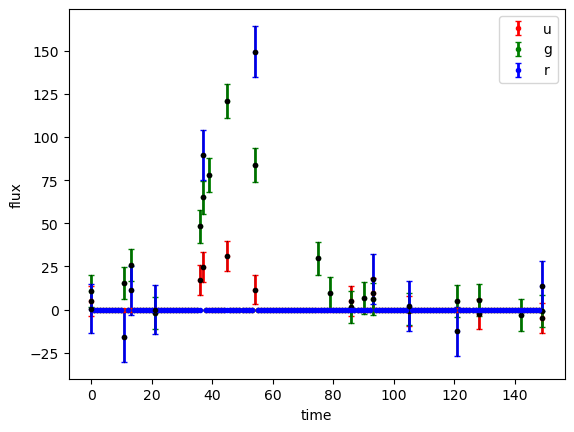

In [33]:
for i in range(3):
    mjd_ = interpolated_data[0][i]
    flux_ = interpolated_data[1][i]
    flux_err_ = interpolated_data[2][i]
    flux_ = flux_ * weight[i]
    flux_err_ = flux_err_ * weight[i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.errorbar(x=lc[0][i], y=lc[1][i], yerr=lc[2][i], fmt=".k",elinewidth=0.2, capsize=0.2)
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")
    #print(weight)

In [34]:
interpolated_data_list = []
weight_list = []
with tqdm(total=sample_size*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
    for sample in range(len(lc_list)):
        lc = lc_list[sample]
        concatnet_lc = concated_lc_list[sample]
        gp_ = gp_parameter_list[sample]
        time = concatnet_lc[0]
        fluxes = concatnet_lc[1]
        flux_errs = concatnet_lc[2]
        filters = concatnet_lc[3]
        try:
            interpolated_data, weight = interpolation(lc=lc)
            interpolated_data_list.append(interpolated_data)
            weight_list.append(weight)
        except:
            fit_fail_list.append(sample)
            print(f"GP failed to fit this data: index{sample}")
        pbar.update(10)

Processing...: 100%|███████████████████████████████████████████| 8.93k/8.93k [00:04<00:00, 2.07kB/s]


In [35]:
sample = 0

In [36]:
sample += 1

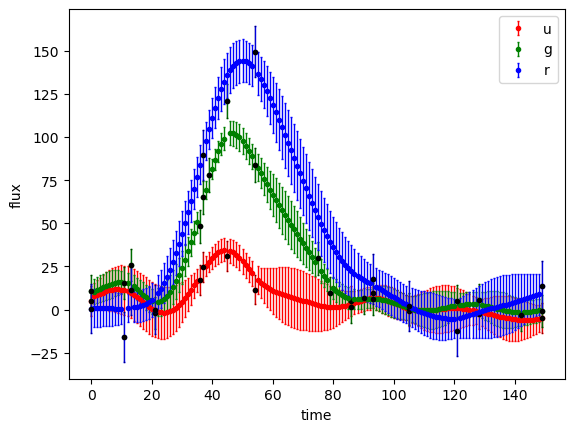

In [37]:
for i in range(3):
    mjd_ = interpolated_data_list[sample][0][i]
    flux_ = interpolated_data_list[sample][1][i]
    flux_err_ = interpolated_data_list[sample][2][i]

    #plt.plot(mjd_, flux_)
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=1, capsize=1,label=label[i])
    plt.errorbar(x=lc_list[sample][0][i], y=lc_list[sample][1][i], yerr=lc_list[sample][2][i], fmt=".k", elinewidth=0.2, capsize=0.2)
    #plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color=color[band], alpha=0.5)
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

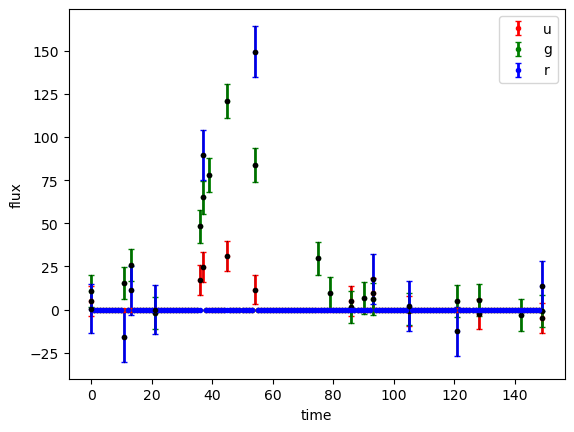

In [38]:
for i in range(3):
    mjd_ = interpolated_data_list[sample][0][i]
    flux_ = interpolated_data_list[sample][1][i]
    flux_err_ = interpolated_data_list[sample][2][i]
    flux_ = flux_ * weight_list[sample][i]
    flux_err_ = flux_err_ * weight_list[sample][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.errorbar(x=lc_list[sample][0][i], y=lc_list[sample][1][i], yerr=lc_list[sample][2][i], fmt=".k", elinewidth=0.2, capsize=0.2)
    #plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color=color[band], alpha=0.5)
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")